In [1]:
import  tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from matplotlib import cm
from matplotlib.ticker import MaxNLocator, LinearLocator
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Function generator
def cos():
    while True:
        x = tf.random.normal((32, 10), np.pi/2, 1.5)
        y = tf.math.cos(x)
        yield (x, y)

In [3]:
# Build the baseline non-residual model
def build_model(blocks_num):
    x = inputs = tf.keras.Input((10, ))
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    for _ in range(blocks_num-1):
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs, x)
    model.compile('adam', 'mse')
    return model

In [4]:
# Build the residual model
def build_res_model(blocks_num):
    x = inputs = tf.keras.Input((10, ))
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    y = x
    for _ in range(blocks_num-1):
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dense(32)(x)
        x = x + y
        x = tf.keras.layers.Activation('relu')(x)
        y = x
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs, x)
    model.compile('adam', 'mse')
    return model

In [5]:
dts = tf.data.Dataset.from_generator(cos, (tf.float32, tf.float32), ((32, 10), (32, 10)))

In [6]:
# Learn baseline model
histories_list_baseline = []
loss = np.inf
for l in range(1, 21):
    baseline_model = build_model(l)
    history = baseline_model.fit(dts, steps_per_epoch=20, epochs=20*l, verbose=False)
    histories_list_baseline.append(history)
    print('Blocks:'+str(l)+'-loss: '+str(history.history['loss'][-1]))
    if history.history['loss'][-1] < loss:
        best_baseline_model = baseline_model
        loss = history.history['loss'][-1]

Blocks:1-loss: 0.3101378083229065
Blocks:2-loss: 0.2259262353181839
Blocks:3-loss: 0.16926468908786774
Blocks:4-loss: 0.11240936815738678
Blocks:5-loss: 0.1324966996908188
Blocks:6-loss: 0.20324046909809113
Blocks:7-loss: 0.18056340515613556
Blocks:8-loss: 0.21214595437049866
Blocks:9-loss: 0.3247617781162262
Blocks:10-loss: 0.30600425601005554
Blocks:11-loss: 0.34002572298049927
Blocks:12-loss: 0.38896745443344116
Blocks:13-loss: 0.39194217324256897
Blocks:14-loss: 0.3822607100009918
Blocks:15-loss: 0.42989349365234375
Blocks:16-loss: 0.4996112883090973
Blocks:17-loss: 0.4928411543369293
Blocks:18-loss: 0.49104294180870056
Blocks:19-loss: 0.49740180373191833
Blocks:20-loss: 0.49210911989212036


In [7]:
# Learn residual model
histories_list_residual = []
loss = np.inf
for l in range(1, 21):
    residual_model = build_res_model(l)
    history = residual_model.fit(dts, steps_per_epoch=20, epochs=20*l, verbose=False)
    histories_list_residual.append(history)
    print('Blocks:'+str(l)+'-loss: '+str(history.history['loss'][-1]))
    if history.history['loss'][-1] < loss:
        best_residual_model = residual_model
        loss = history.history['loss'][-1]

Blocks:1-loss: 0.30164867639541626
Blocks:2-loss: 0.25448572635650635
Blocks:3-loss: 0.19715772569179535
Blocks:4-loss: 0.1808321624994278
Blocks:5-loss: 0.14206942915916443
Blocks:6-loss: 0.10014061629772186
Blocks:7-loss: 0.12145636230707169
Blocks:8-loss: 0.0761217251420021
Blocks:9-loss: 0.036434538662433624
Blocks:10-loss: 0.042939066886901855
Blocks:11-loss: 0.06602165848016739
Blocks:12-loss: 0.054333992302417755
Blocks:13-loss: 0.024562101811170578
Blocks:14-loss: 0.04007042571902275
Blocks:15-loss: 0.039492398500442505
Blocks:16-loss: 0.04596065729856491
Blocks:17-loss: 0.04191827028989792
Blocks:18-loss: 0.042361993342638016
Blocks:19-loss: 0.03714442253112793
Blocks:20-loss: 0.03324100002646446


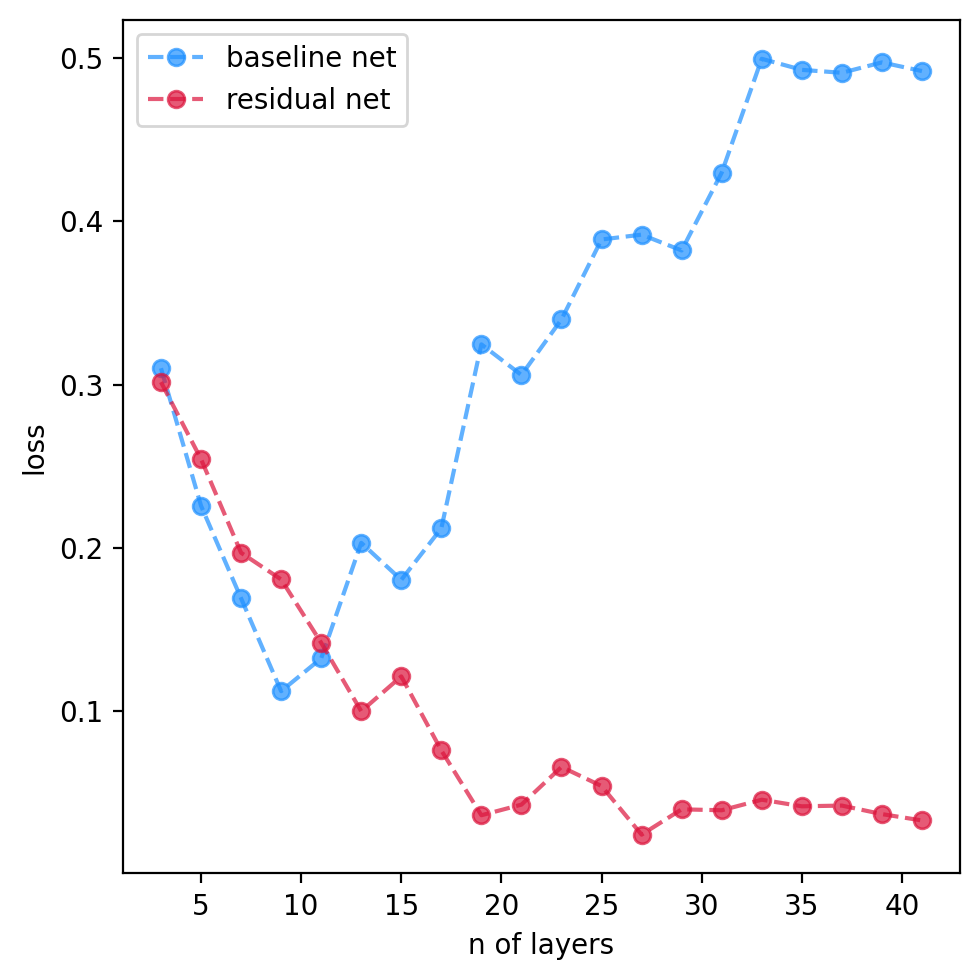

In [16]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 200
x = [2*l+1 for l in range(1, 21)]
y_base = [hist.history['loss'][-1] for hist in histories_list_baseline]
y_res = [hist.history['loss'][-1] for hist in histories_list_residual]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y_base, color='dodgerblue', alpha=0.7, linestyle='--', marker='o', label='baseline net')
ax.plot(x, y_res, color='crimson', alpha=0.7, linestyle='--', marker='o', label='residual net')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('n of layers')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()
plt.show()

In [9]:
fig.savefig('baseline_vs_residual_training_loss.pdf', dpi=300)

### Loss landscape visualization

In [11]:
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from sklearn.decomposition import PCA

In [12]:
class RandomCoordinates(object):
    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


class LossSurface(object):
    def __init__(self, model, batch_size):
        self.model_ = model
        self.batch_size = batch_size
        self.inputs = tf.random.normal((self.batch_size, 10), np.pi/2, 1.5)
        self.outputs = tf.math.cos(self.inputs)

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                self.model_.set_weights(coords(a, b))
                loss = self.model_.test_on_batch(
                    self.inputs, self.outputs, return_dict=True
                )["loss"]
                loss_grid[j, i] = loss
        self.model_.set_weights(coords.origin_)
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=20, ax=None, axtitle='', **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(
                tf.math.log(min_loss), tf.math.log(max_loss), num=levels
            )
        )
        # Create Contour Plot
        CS = ax.contour(
            xs,
            ys,
            zs,
            levels=levels,
            cmap='magma',
            linewidths=0.75,
            norm=mplc.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
        )
        ax.clabel(CS, inline=True, fontsize=8, fmt='%1.2f')
        ax.set_title(axtitle)
        return ax
    
    def plot3D(self, range=1.0, ax=None, log_scale=True, axtitle='', **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if log_scale:
            zs = np.log10(zs)
        X, Y = np.meshgrid(xs, ys)
        min_loss = zs.min()
        max_loss = zs.max()
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
        # Create a surface plot
        if log_scale:
            surf = ax.plot_surface(X, Y, zs, cmap=cm.magma,
                           linewidth=0,
                           antialiased=False, shade=True)
            ax.plot_wireframe(X, Y, zs, color='grey')
        else:
            surf = ax.plot_surface(X, Y, zs, cmap=cm.magma,
                       linewidth=0, norm=mplc.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
                       antialiased=False, shade=True)
            ax.plot_wireframe(X, Y, zs, norm=mplc.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
                             color='grey')
        # Set z axis limits
        #ax.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        #ax.zaxis.set_major_formatter('{x:.02f}')
        ax.set_title(axtitle)
        return (ax, surf)
    
    # Some utility functions to reshape network weights
def vectorize_weights_(weights):
    vec = [w.flatten() for w in weights]
    vec = np.hstack(vec)
    return vec


def vectorize_weight_list_(weight_list):
    vec_list = []
    for weights in weight_list:
        vec_list.append(vectorize_weights_(weights))
    weight_matrix = np.column_stack(vec_list)
    return weight_matrix


def shape_weight_matrix_like_(weight_matrix, example):
    weight_vecs = np.hsplit(weight_matrix, weight_matrix.shape[1])
    sizes = [v.size for v in example]
    shapes = [v.shape for v in example]
    weight_list = []
    for net_weights in weight_vecs:
        vs = np.split(net_weights, np.cumsum(sizes))[:-1]
        vs = [v.reshape(s) for v, s in zip(vs, shapes)]
        weight_list.append(vs)
    return weight_list


def get_path_components_(training_path, n_components=2):
    # Vectorize network weights
    weight_matrix = vectorize_weight_list_(training_path)
    # Create components
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(weight_matrix)
    # Reshape to fit network
    example = training_path[0]
    weight_list = shape_weight_matrix_like_(components, example)
    return pca, weight_list


class PCACoordinates(object):
    def __init__(self, training_path):
        origin = training_path[-1]
        self.pca_, self.components = get_path_components_(training_path)
        self.set_origin(origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]

    def set_origin(self, origin, renorm=True):
        self.origin_ = origin
        if renorm:
            self.v0_ = normalize_weights(self.components[0], origin)
            self.v1_ = normalize_weights(self.components[1], origin)

In [13]:
# Learn the two models
l = 20
baseline_model = build_model(l)
training_path_base = [baseline_model.get_weights()]
collect_weights_base = callbacks.LambdaCallback(
                        on_epoch_end=(
                        lambda batch, logs: training_path_base.append(baseline_model.get_weights())))
print('Training baseline model')
history_base = baseline_model.fit(dts, steps_per_epoch=20, epochs=20*l,
                              callbacks=[collect_weights_base], verbose=False)
print('baseline loss:'+str(history_base.history['loss'][-1]))
residual_model = build_res_model(l)
training_path_res = [residual_model.get_weights()]
collect_weights_res = callbacks.LambdaCallback(
                        on_epoch_end=(
                        lambda batch, logs: training_path_res.append(residual_model.get_weights())))
print('Training residual model')
history_res = residual_model.fit(dts, steps_per_epoch=20, epochs=20*l,
                              callbacks=[collect_weights_res], verbose=False)
print('residual loss:'+str(history_res.history['loss'][-1]))

Training baseline model
baseline loss:0.49088066816329956
Training residual model
residual loss:0.06993677467107773


In [14]:
# Create loss surface along PCAs coordinates
coords_base = PCACoordinates(training_path_base)
coords_res = PCACoordinates(training_path_res)
print('Baseline model')
loss_surface_base = LossSurface(baseline_model, batch_size=32)
loss_surface_base.compile(points=200, coords=coords_base, range=0.05)
print('Residual model')
loss_surface_res = LossSurface(residual_model, batch_size=32)
loss_surface_res.compile(points=200, coords=coords_res, range=0.05)

Baseline model
Residual model


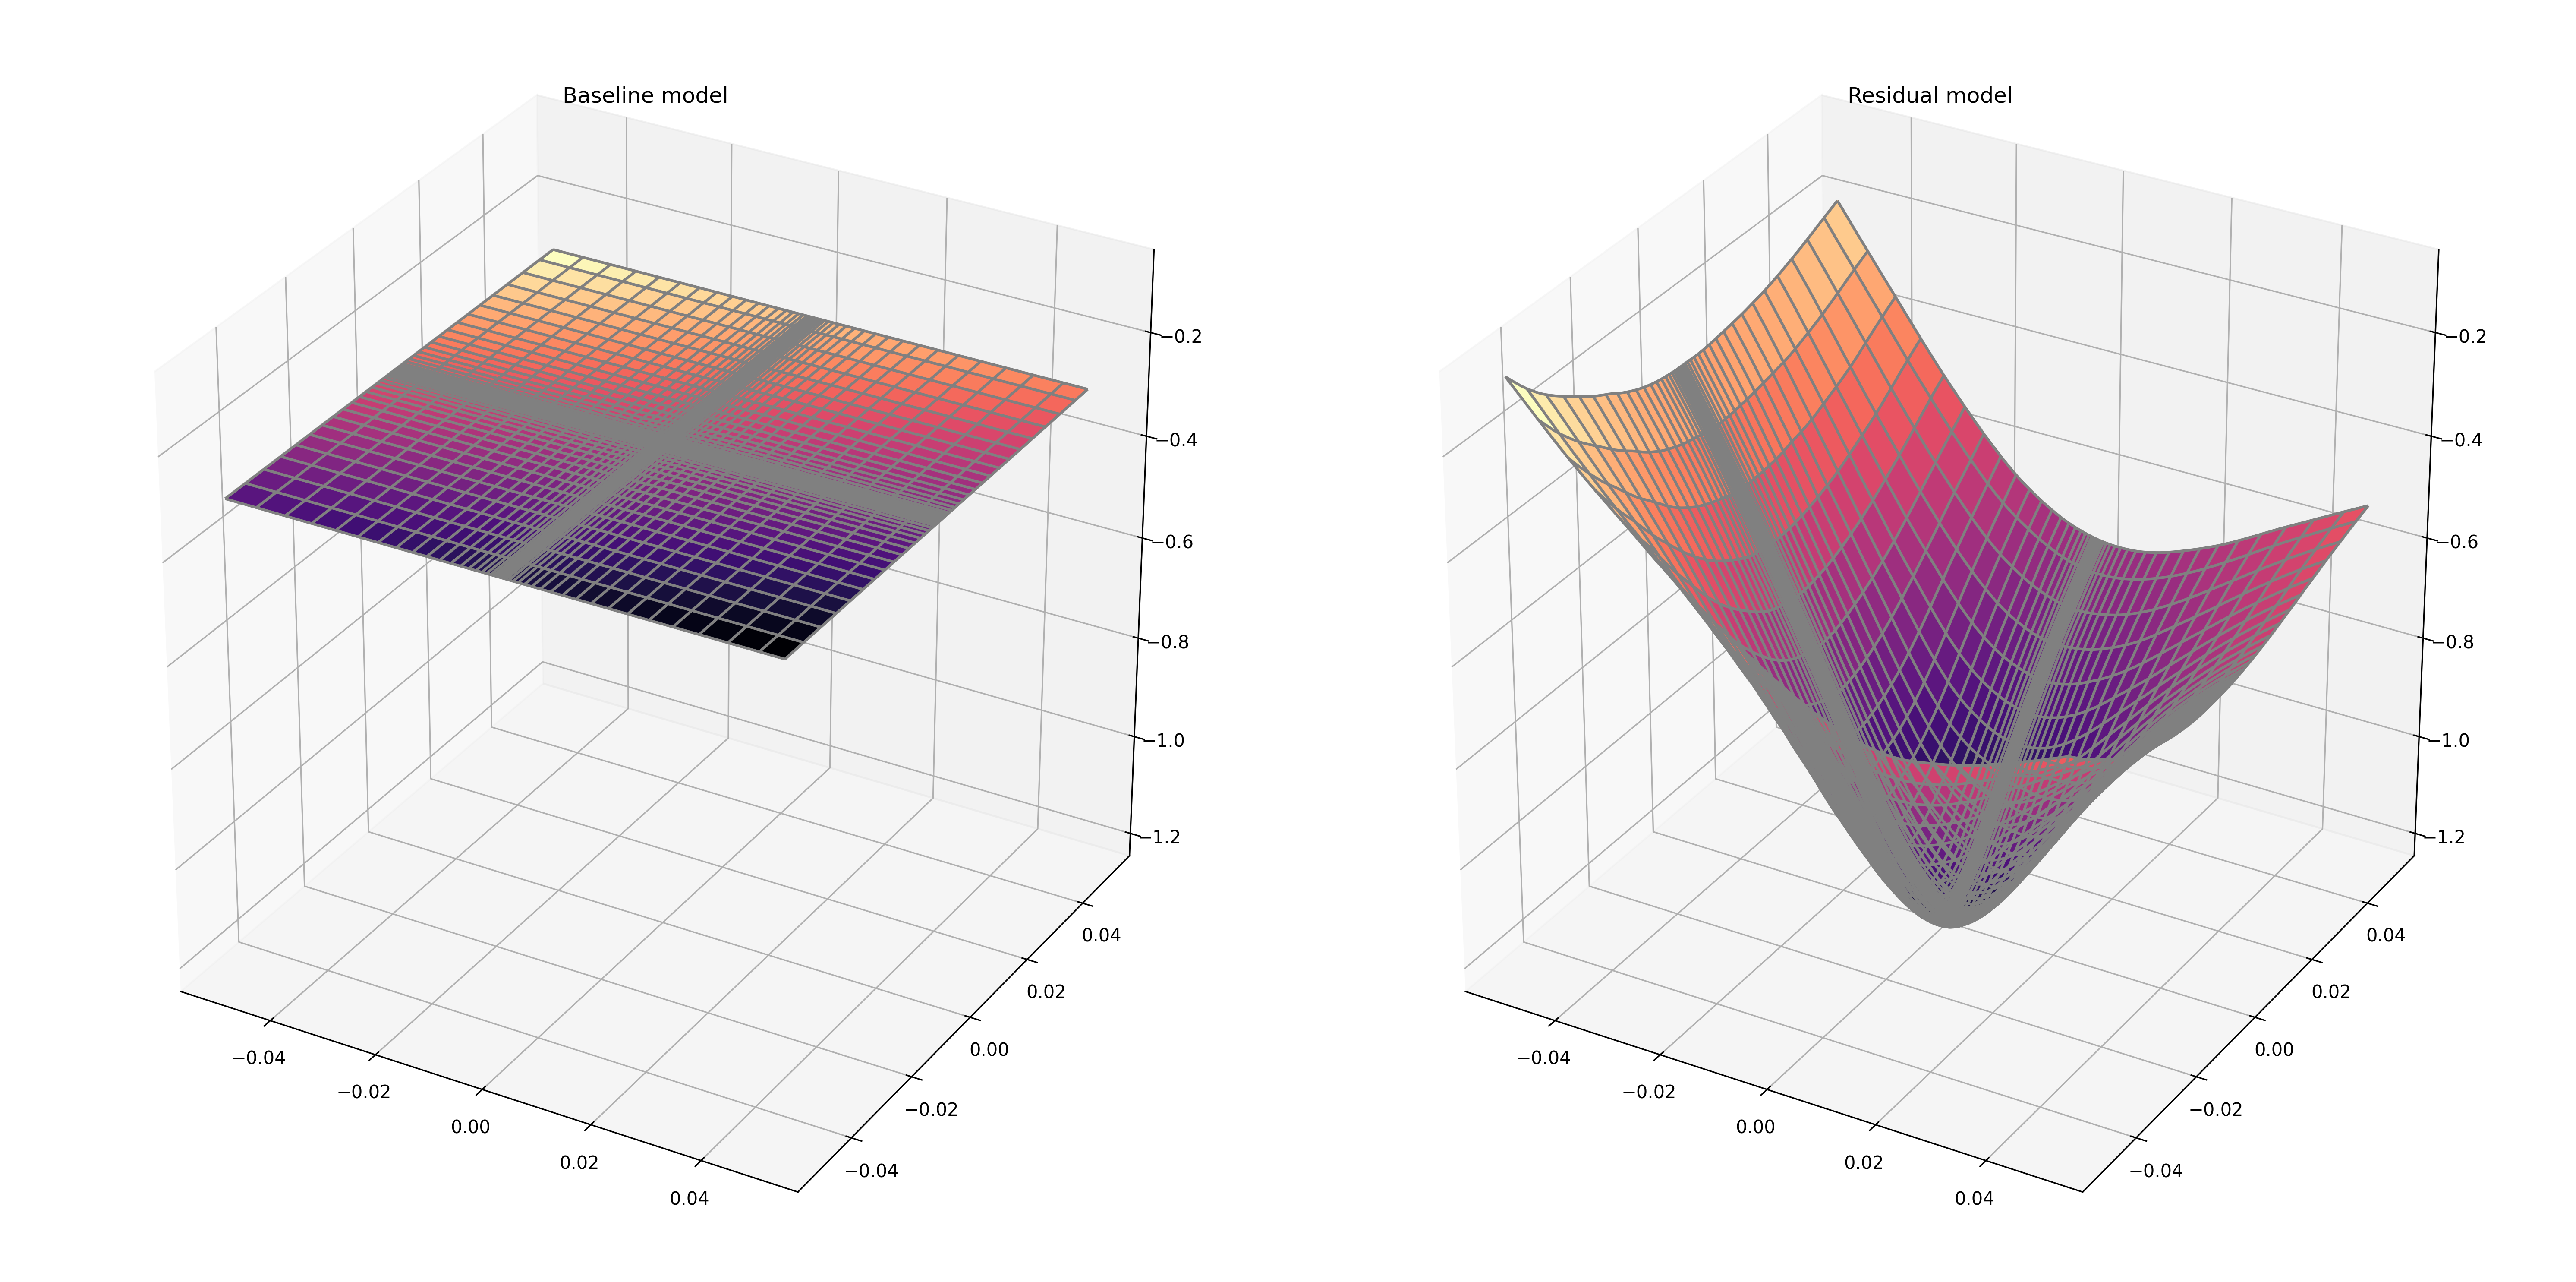

In [17]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 300
fig = plt.figure()
ax_base = fig.add_subplot(121, projection='3d')
ax_res = fig.add_subplot(122, sharez=ax_base, projection='3d')
_, surf_base = loss_surface_base.plot3D(ax=ax_base, dpi=150, wireframe=True,
                                        log_scale=True, axtitle='Baseline model')
_, surf_res = loss_surface_res.plot3D(ax=ax_res, dpi=150, wireframe=True,
                                      log_scale=True, axtitle='Residual model')
#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.tight_layout()
plt.show()

In [ ]:
fig.savefig('baseline_vs_residual_landscape3d_20_blocks.pdf', dpi=300)

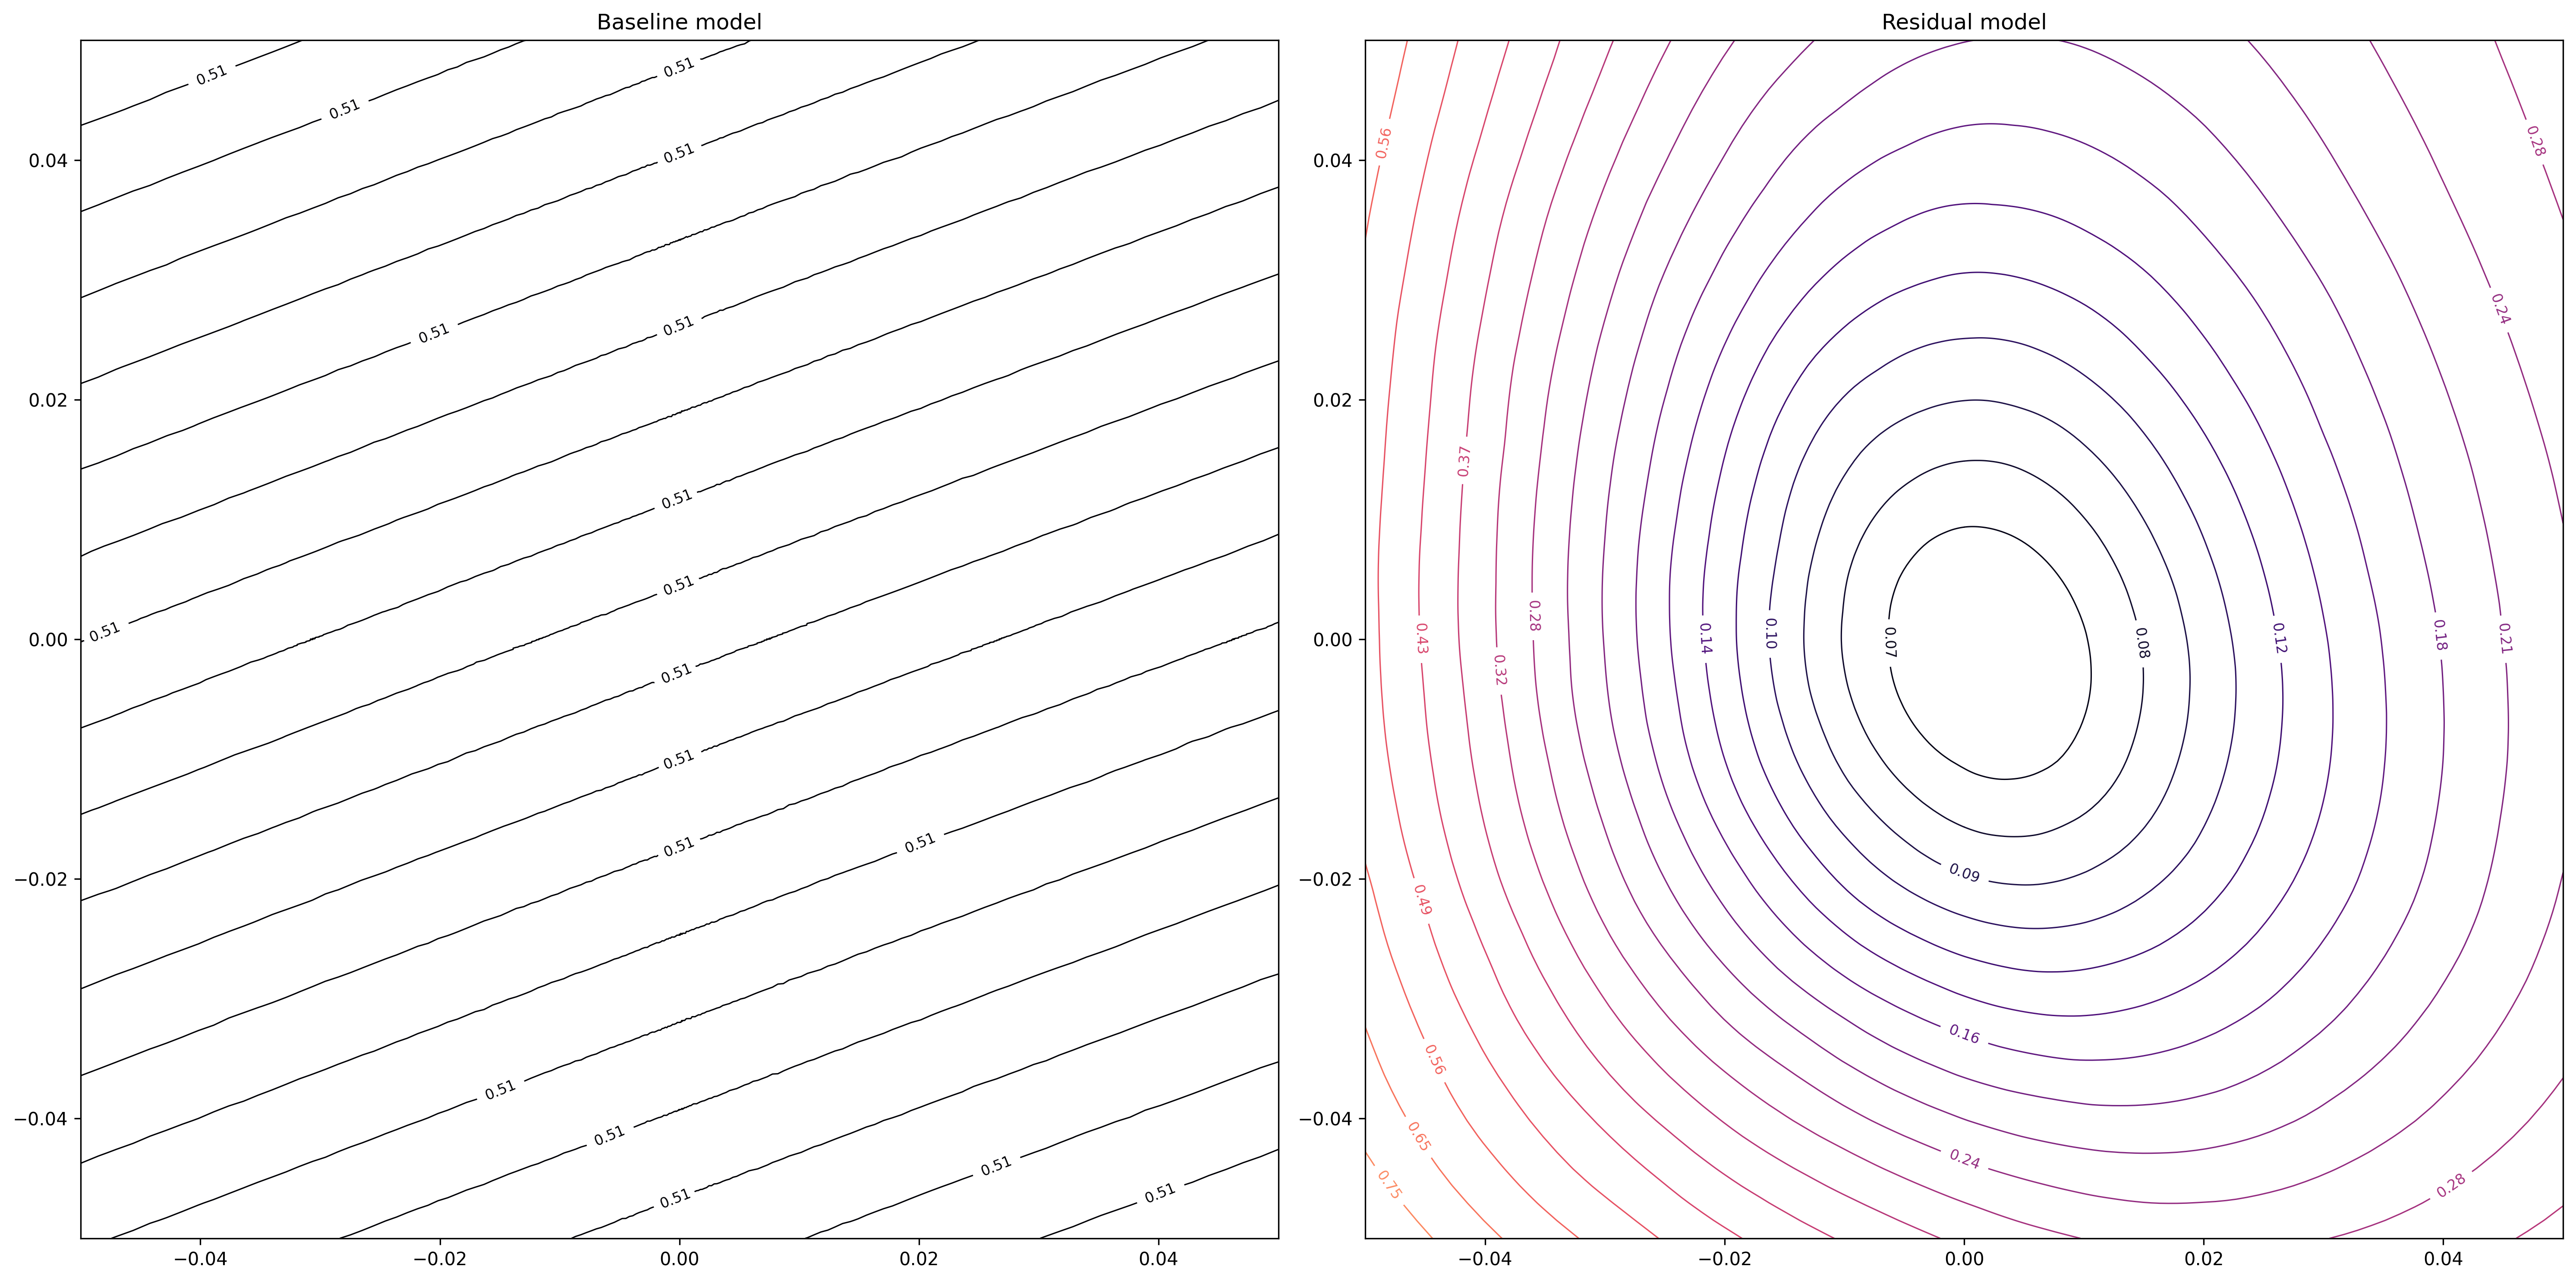

In [18]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 300
fig, (ax_base, ax_res) = plt.subplots(nrows=1, ncols=2)
loss_surface_base.plot(ax=ax_base, axtitle='Baseline model', dpi=150)
loss_surface_res.plot(ax=ax_res, axtitle='Residual model', dpi=150)
fig.tight_layout()
plt.show()

In [ ]:
fig.savefig('baseline_vs_residual_contours_20_blocks.pdf', dpi=300)